In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from tqdm import tqdm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Collect Data

In [80]:
tickers_names = {"SHEL": "Shell",
                 "XOM": "ExxonMobil",
                 "BP": "BP",
                 "CVX": "Chevron"}

def FetchStockData(ticker_symbol, company_name):
    ticker = yf.Ticker(ticker_symbol)
    today = datetime.date.today().strftime('%Y-%m-%d')
    data = ticker.history(start="2021-01-01", end=today)
    
    # Reset the index and keep 'Date' as a column
    data.reset_index(inplace=True)
    
    # Ensure the 'Date' column is in the correct format
    if pd.api.types.is_datetime64_any_dtype(data['Date']):
        data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
    
    # Drop unnecessary columns
    data.drop(columns=['Dividends', 'Stock Splits'], inplace=True, errors='ignore')
    
    # Add additional columns for ticker and commodity
    data['ticker'] = ticker_symbol  
    data['company'] = company_name  
    
    # Convert all column names to lowercase for consistency
    data.columns = [col.lower() for col in data.columns]
    
    # Reorder columns to place 'ticker', 'commodity', and 'date' at the beginning
    data = data[['ticker', 'company', 'date'] + [col for col in data.columns if col not in ['ticker', 'company', 'date']]]
    data['date'] = pd.to_datetime(data['date'])

    return data



# 2. Loop over each symbol and append data to a DataFrame
all_data = []
for symbol, name in tickers_names.items():
    all_data.append(FetchStockData(symbol, name))

# Concatenate all the individual datasets into one
stock_data = pd.concat(all_data, ignore_index=True)
stock_data.to_csv('stock_data.csv', index = False)


# Inspect Data

## General

In [81]:
print("Energy Stock Prices Dataset Info:")
print(stock_data.info())

Energy Stock Prices Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4068 entries, 0 to 4067
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ticker   4068 non-null   object        
 1   company  4068 non-null   object        
 2   date     4068 non-null   datetime64[ns]
 3   open     4068 non-null   float64       
 4   high     4068 non-null   float64       
 5   low      4068 non-null   float64       
 6   close    4068 non-null   float64       
 7   volume   4068 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 254.4+ KB
None


In [82]:
print("Energy Stock Prices Dataset Description:")
print(stock_data.describe())

Energy Stock Prices Dataset Description:
                                date         open         high          low  \
count                           4068  4068.000000  4068.000000  4068.000000   
mean   2023-01-09 22:39:17.522124032    75.905151    76.636762    75.155586   
min              2021-01-04 00:00:00    17.060681    17.431918    16.854433   
25%              2022-01-05 00:00:00    35.746207    36.035127    35.464462   
50%              2023-01-10 00:00:00    62.276815    62.621033    61.907388   
75%              2024-01-16 00:00:00   107.440539   108.728462   106.555015   
max              2025-01-21 00:00:00   171.284651   173.627987   170.424181   
std                              NaN    43.984313    44.409797    43.523298   

             close        volume  
count  4068.000000  4.068000e+03  
mean     75.909396  1.145801e+07  
min      17.118427  7.529140e+05  
25%      35.671244  5.903550e+06  
50%      62.299900  9.065500e+06  
75%     107.487722  1.468300e+07  
ma

In [83]:
print("The Number of Instances for Each Company:")
print(stock_data['company'].value_counts())

The Number of Instances for Each Company:
company
Shell         1017
ExxonMobil    1017
BP            1017
Chevron       1017
Name: count, dtype: int64


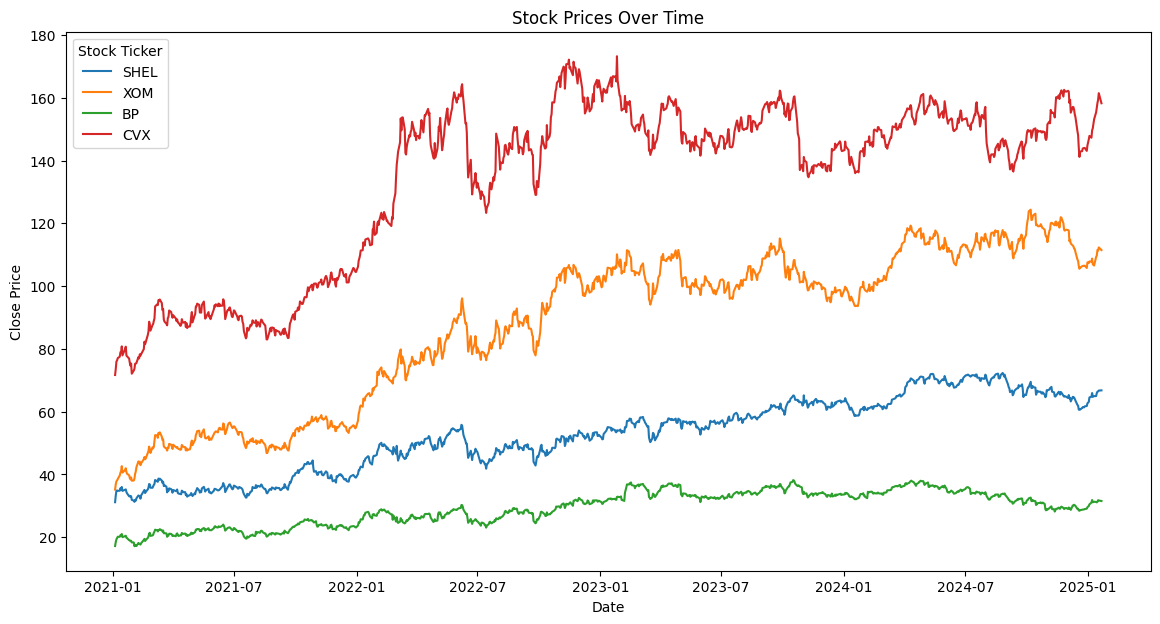

In [84]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=stock_data, x='date', y='close', hue='ticker')
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(title='Stock Ticker')
plt.show()

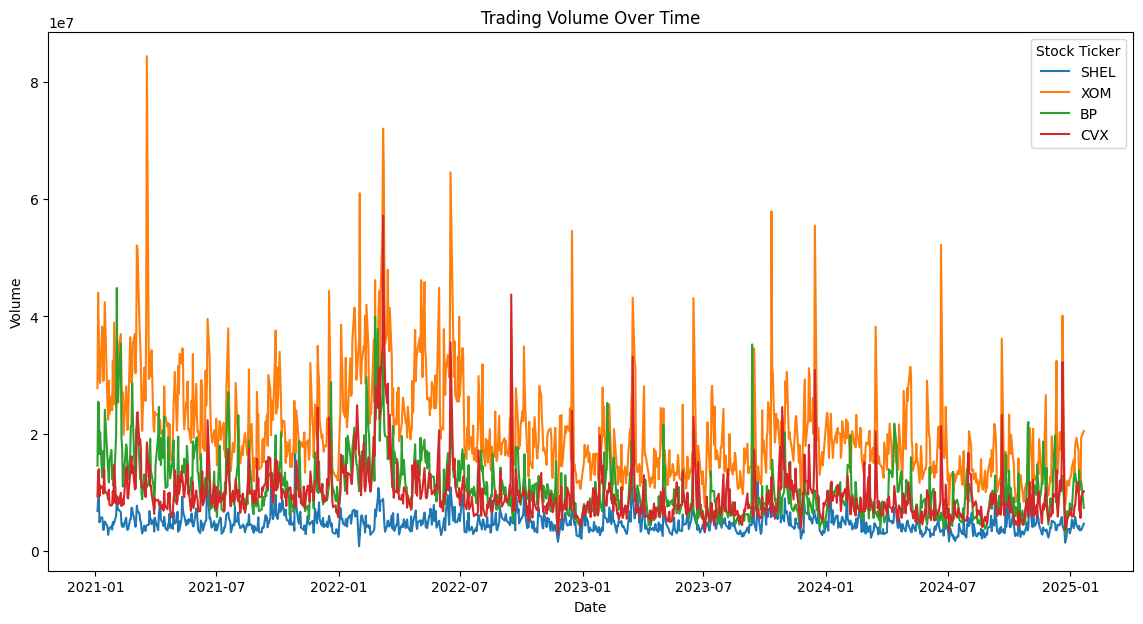

In [85]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=stock_data, x='date', y='volume', hue='ticker')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(title='Stock Ticker')
plt.show()

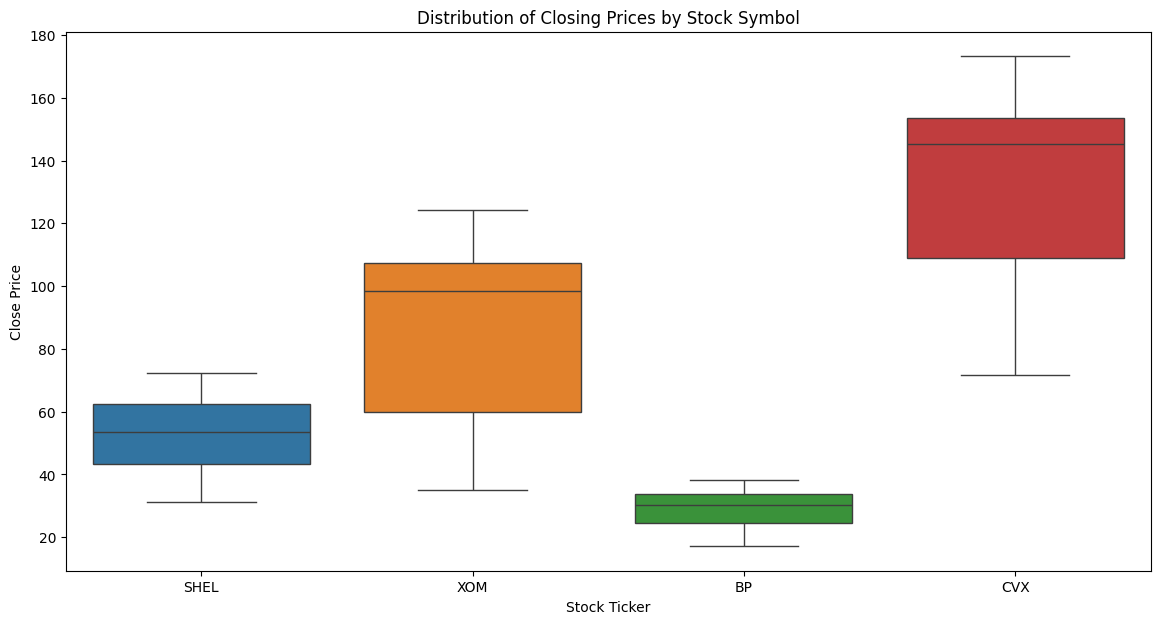

In [86]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=stock_data, x='ticker', y='close', hue='ticker')
plt.title('Distribution of Closing Prices by Stock Symbol')
plt.xlabel('Stock Ticker')
plt.ylabel('Close Price')
plt.show()

In [87]:
pivot_table = stock_data.pivot(index='date', columns='ticker', values='close')
pivot_table

ticker,BP,CVX,SHEL,XOM
date,,,,
2021-01-04,17.184423,71.667793,31.141003,35.163219
2021-01-05,18.463152,73.605217,33.284477,36.857841
2021-01-06,19.312887,75.974106,34.822948,37.798344
2021-01-07,19.725372,76.329453,34.866165,38.094898
2021-01-08,20.129620,77.057045,34.779739,38.518555
...,...,...,...,...
2025-01-14,31.090000,156.899994,65.910004,109.720001
2025-01-15,31.299999,158.330002,66.360001,111.510002
2025-01-16,31.780001,159.380005,66.449997,111.320000


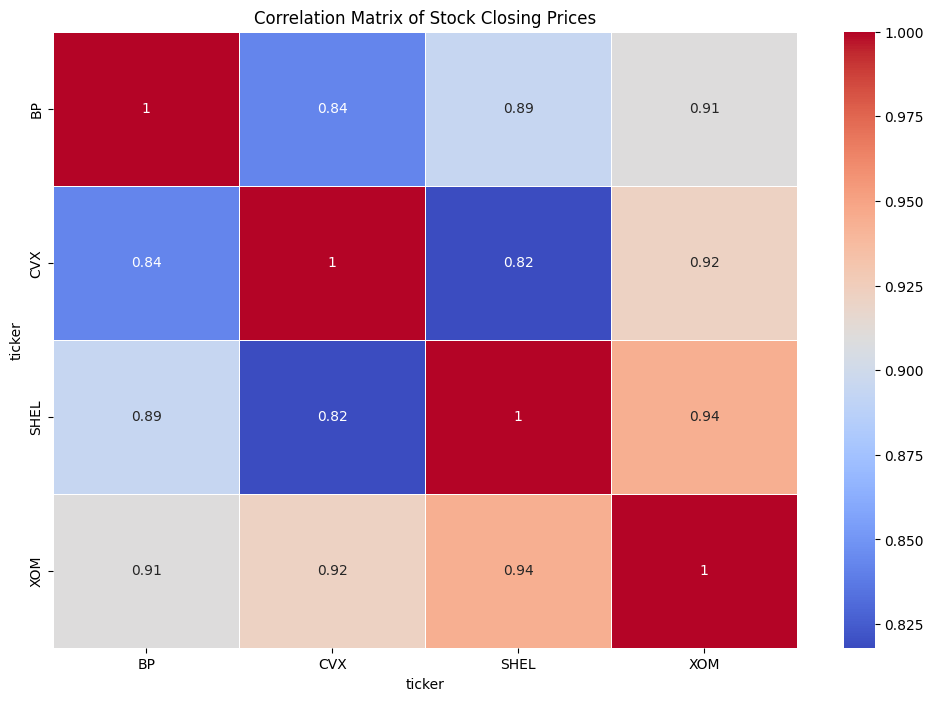

In [88]:
correlation_matrix = pivot_table.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Stock Closing Prices')
plt.show()

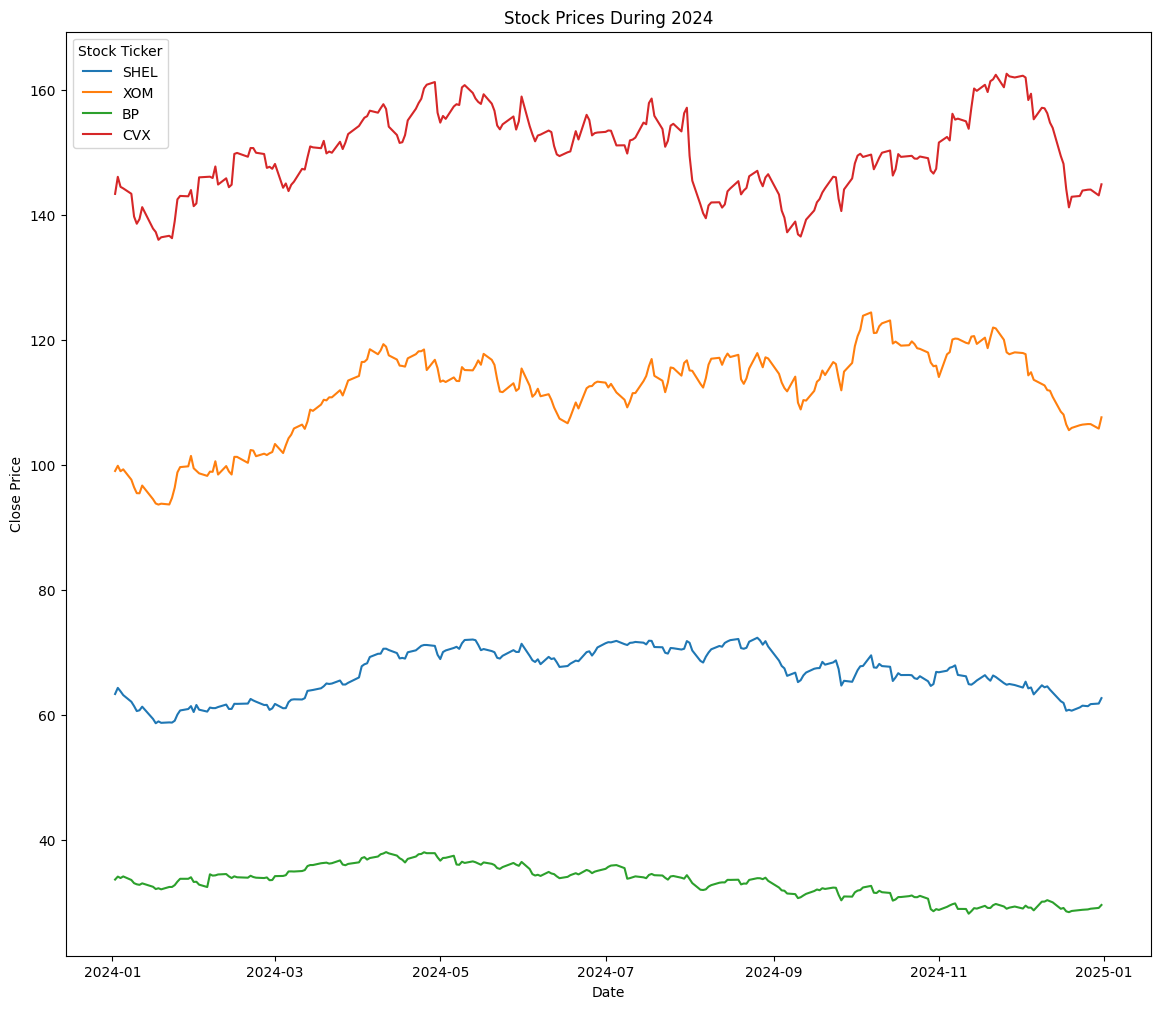

In [89]:
stock_data_2024 = stock_data[(stock_data['date'] >= '2024-01-01') & (stock_data['date'] <= '2024-12-31')]

plt.figure(figsize= (14, 12))
sns.lineplot(data = stock_data_2024, x = 'date', y = 'close', hue = 'ticker')
plt.title('Stock Prices During 2024')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(title = 'Stock Ticker')
plt.show()

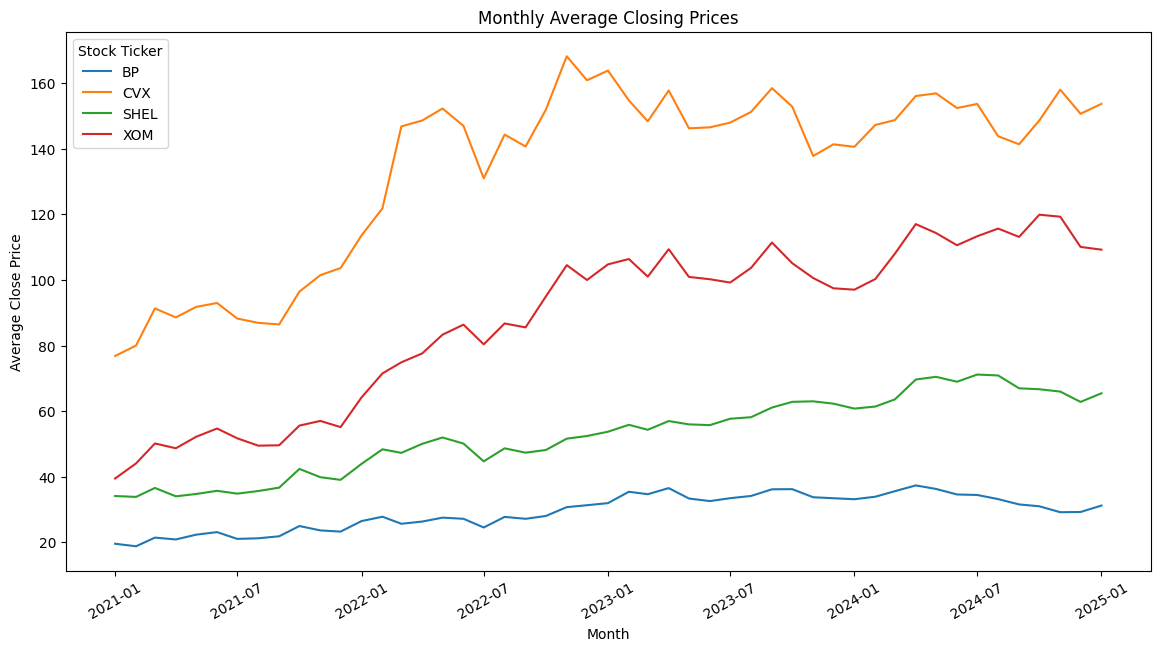

In [90]:
stock_data['month'] = stock_data['date'].dt.to_period('M').dt.to_timestamp()
monthly_avg_prices = stock_data.groupby(['month', 'ticker']).mean(numeric_only=True).reset_index()

plt.figure(figsize = (14, 7))
sns.lineplot(data = monthly_avg_prices, x = 'month', y = 'close', hue = 'ticker')
plt.title('Monthly Average Closing Prices')
plt.xlabel('Month')
plt.ylabel('Average Close Price')
plt.xticks(rotation = 30)
plt.legend(title = 'Stock Ticker')
plt.show()

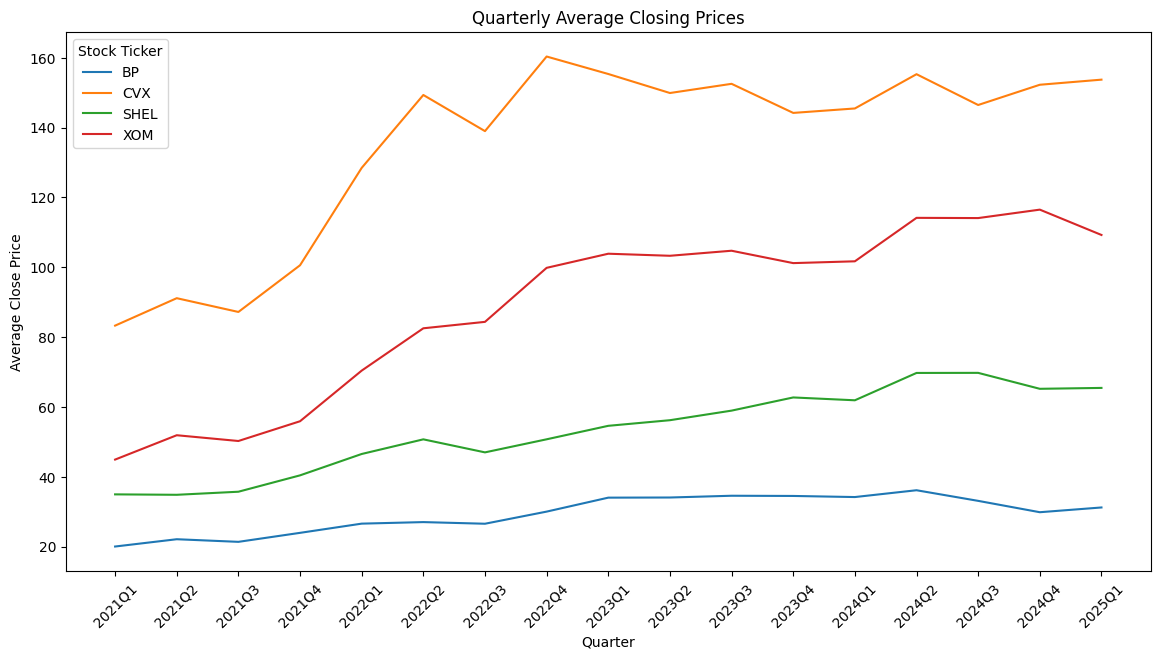

In [91]:
stock_data['quarter'] = stock_data['date'].dt.to_period('Q')
quarterly_avg_prices = stock_data.groupby(['quarter', 'ticker']).mean(numeric_only=True).reset_index()
quarterly_avg_prices['quarter'] = quarterly_avg_prices['quarter'].astype(str)

plt.figure(figsize = (14, 7))
sns.lineplot(data = quarterly_avg_prices, x = 'quarter', y = 'close', hue = 'ticker')
plt.title('Quarterly Average Closing Prices')
plt.xlabel('Quarter')
plt.ylabel('Average Close Price')
plt.xticks(rotation = 45)
plt.legend(title = 'Stock Ticker')
plt.show()

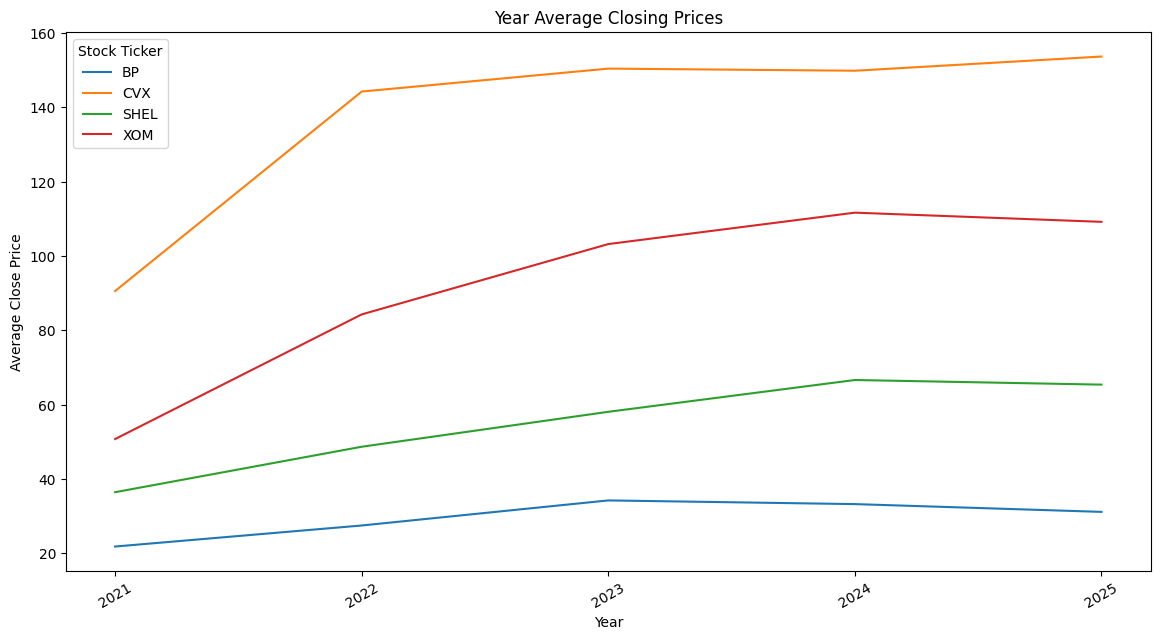

In [105]:
stock_data['year'] = stock_data['date'].dt.year
yearly_avg_prices = stock_data.groupby(['year', 'ticker']).mean(numeric_only=True).reset_index()
yearly_avg_prices['year'] = yearly_avg_prices['year'].astype(int)

plt.figure(figsize = (14, 7))
sns.lineplot(data = yearly_avg_prices, x = 'year', y = 'close', hue = 'ticker')
plt.title('Year Average Closing Prices')
plt.xlabel('Year')
plt.ylabel('Average Close Price')
plt.xticks(ticks=yearly_avg_prices['year'].unique(), rotation=30)
plt.legend(title = 'Stock Ticker')
plt.show()

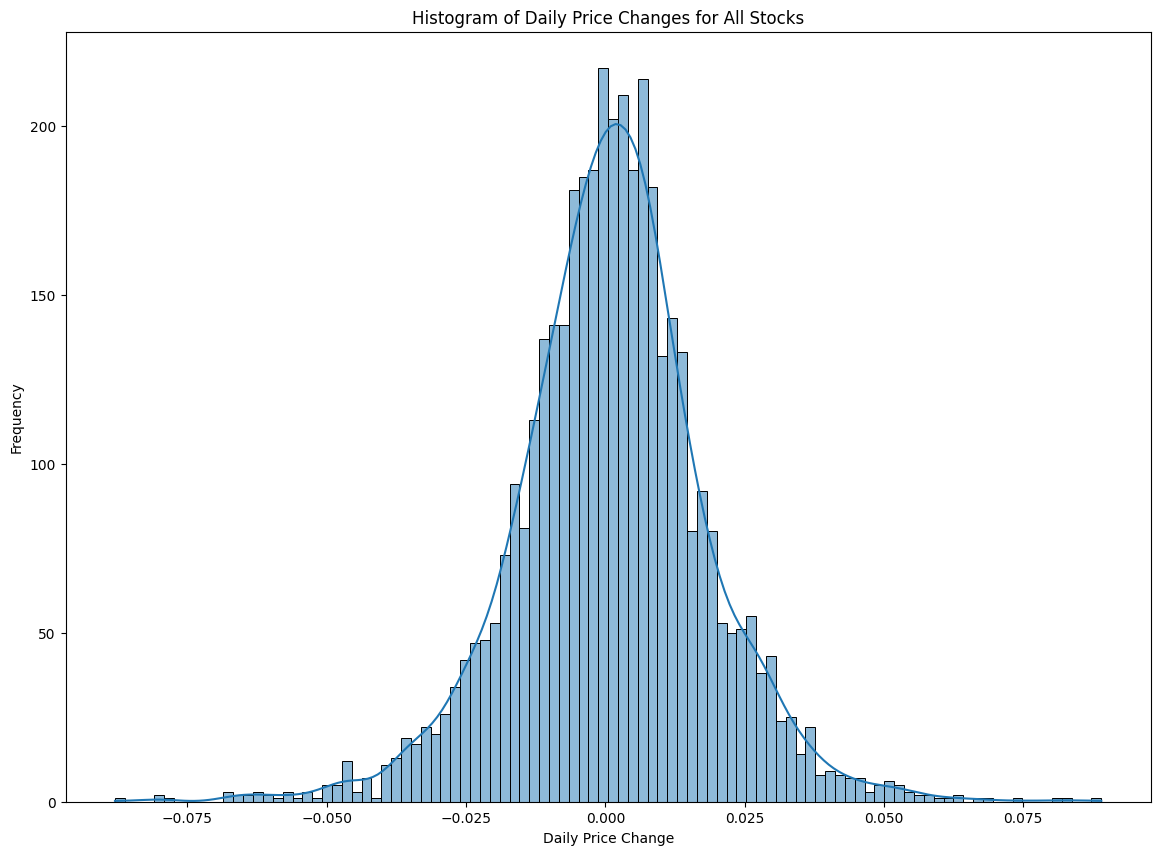

In [93]:
stock_data['price_change'] = stock_data.groupby('ticker')['close'].pct_change() # percentage change

plt.figure(figsize = (14, 10))

sns.histplot(stock_data['price_change'].dropna(), bins = 100, kde = True)
plt.title('Histogram of Daily Price Changes for All Stocks')
plt.xlabel('Daily Price Change')
plt.ylabel('Frequency')
plt.show()

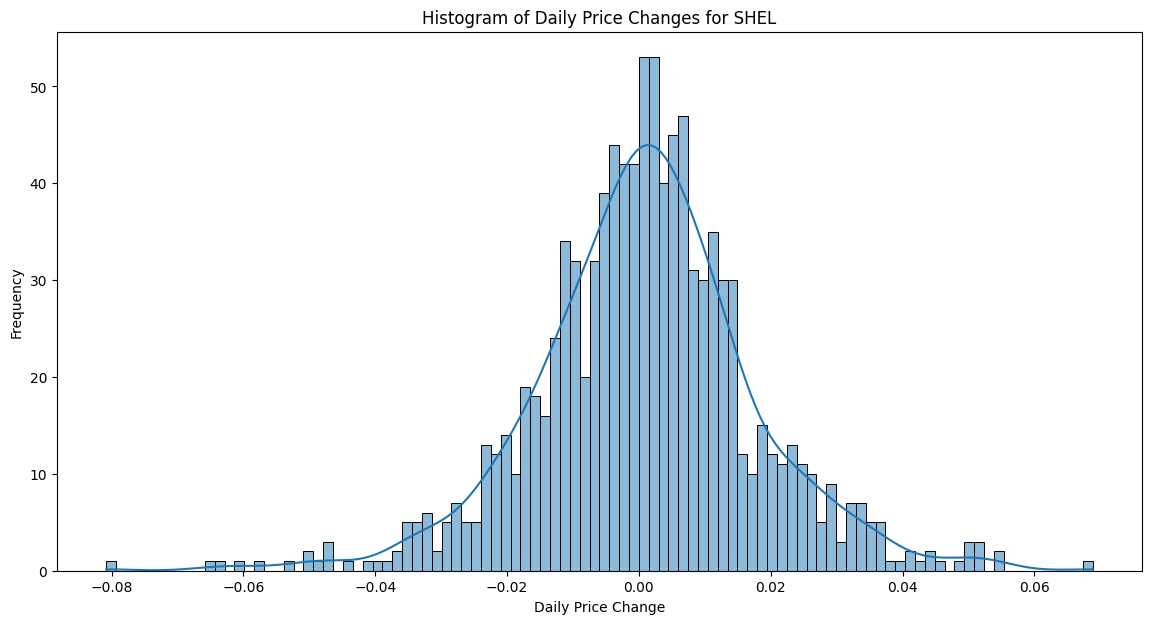

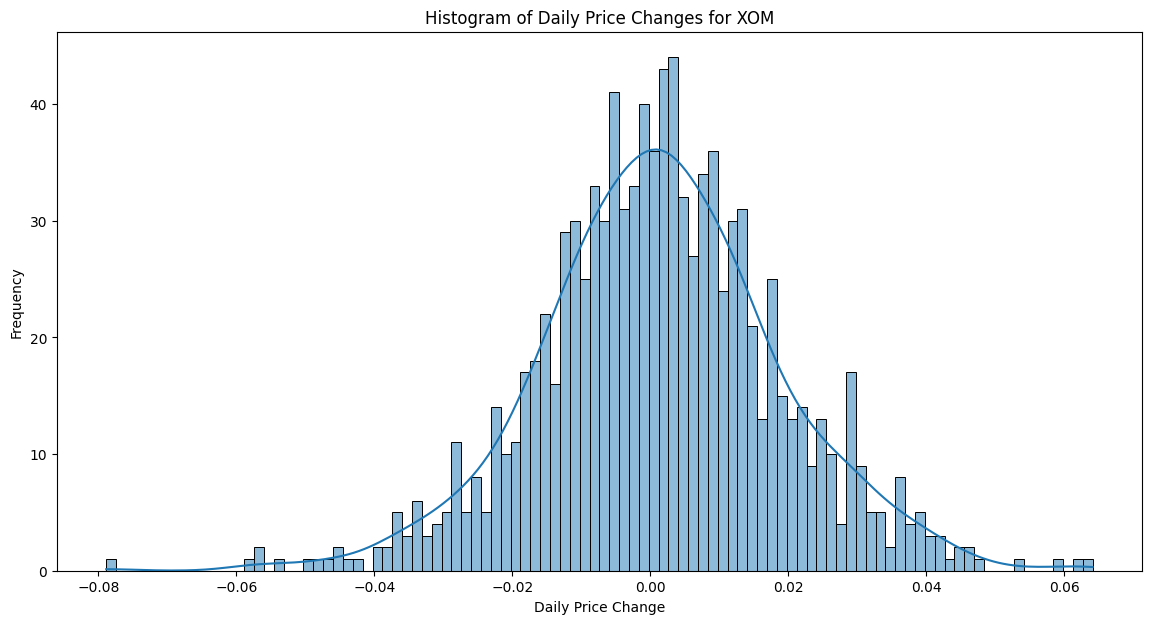

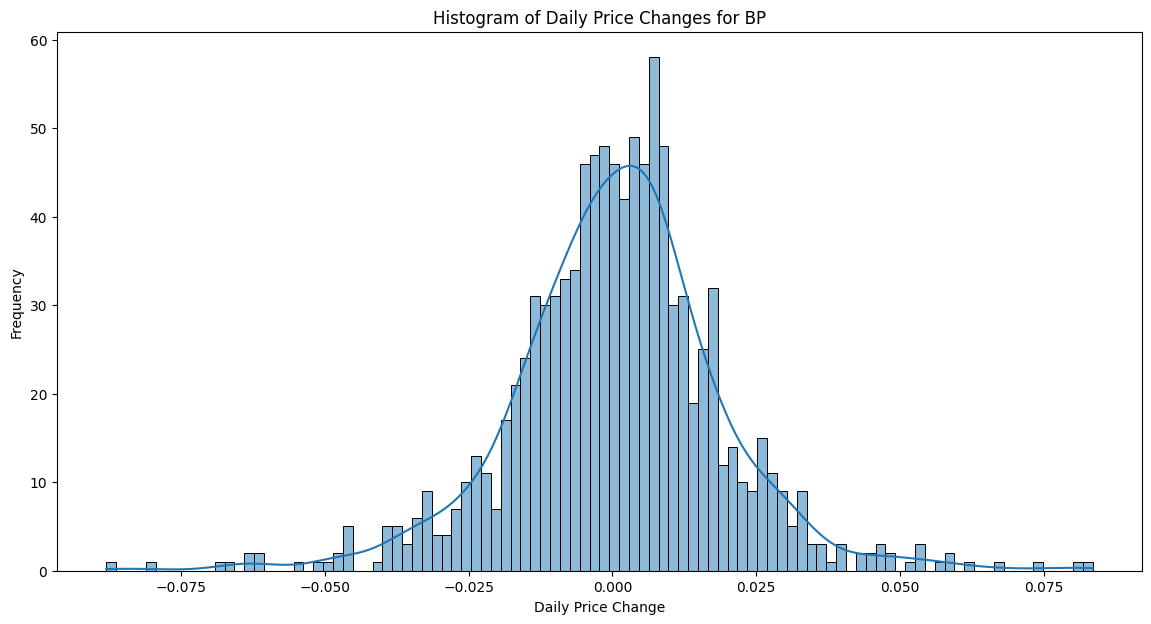

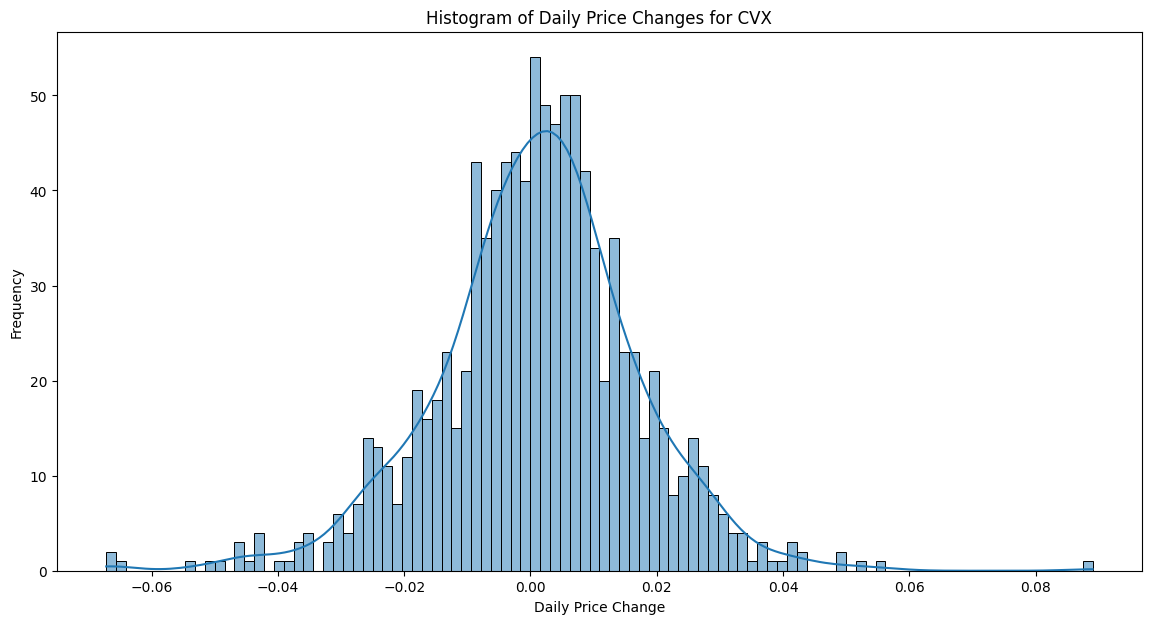

In [94]:
unique_tickers = stock_data['ticker'].unique()

for t in unique_tickers:
    plt.figure(figsize = (14, 7))
    sns.histplot(stock_data[stock_data['ticker'] == t]['price_change'].dropna(), bins = 100, kde = True)
    plt.title(f"Histogram of Daily Price Changes for {t}")
    plt.xlabel('Daily Price Change')
    plt.ylabel('Frequency')
    plt.show()

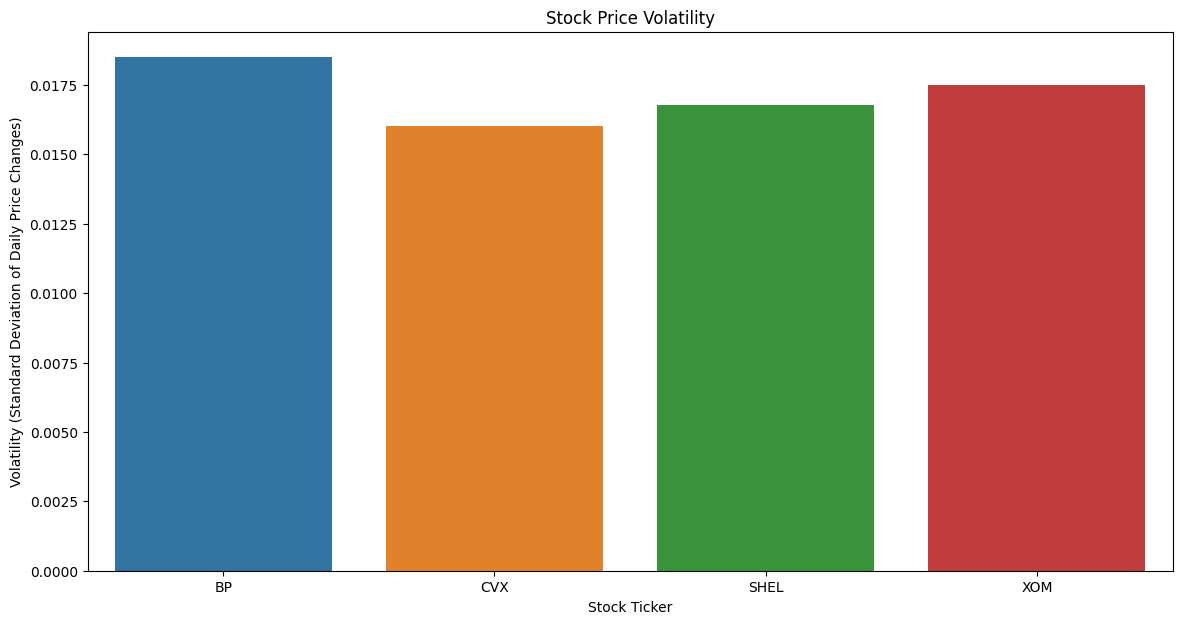

In [95]:
volatility = stock_data.groupby('ticker')['price_change'].std().reset_index()
volatility.columns = ['ticker', 'volatility']

plt.figure(figsize = (14, 7))
sns.barplot(data = volatility, x = 'ticker', y = 'volatility', hue = 'ticker')
plt.title('Stock Price Volatility')
plt.xlabel('Stock Ticker')
plt.ylabel('Volatility (Standard Deviation of Daily Price Changes)')
plt.show()

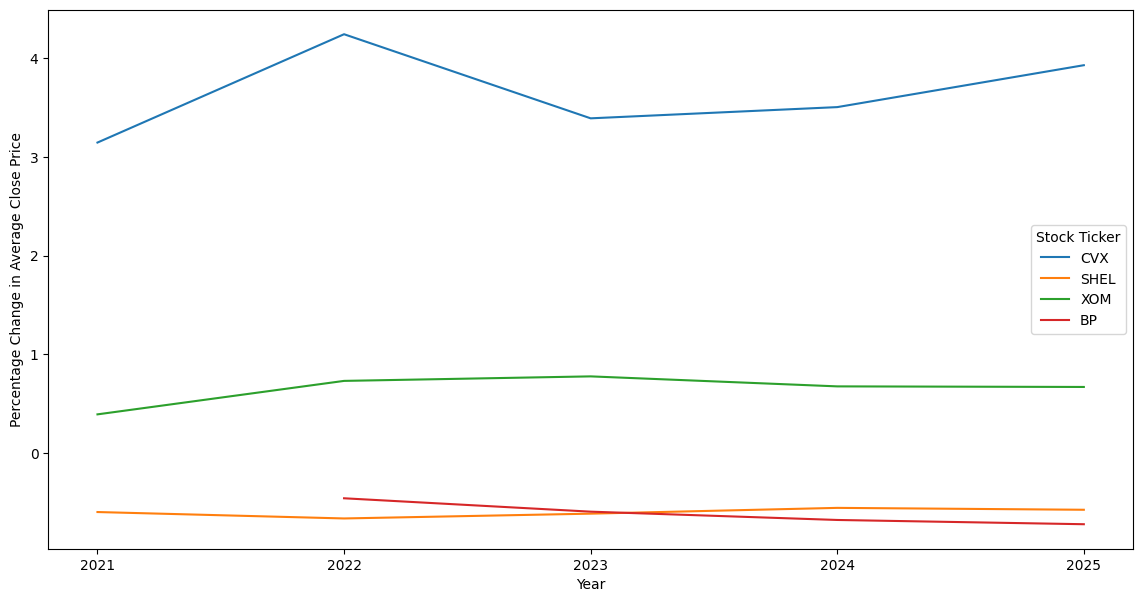

In [107]:
yearly_price_change = stock_data.groupby(['year', 'ticker'])['close'].mean().pct_change().reset_index()
yearly_price_change = yearly_price_change.dropna()

plt.figure(figsize=(14, 7))
sns.lineplot(data = yearly_price_change, x = 'year', y = 'close', hue = 'ticker')
plt.xlabel('Year')
plt.ylabel('Percentage Change in Average Close Price')
plt.xticks(ticks=yearly_price_change['year'].unique()) # Display integer instead of decimal number as year
plt.legend(title = 'Stock Ticker')
plt.show()

## Shell

In [97]:
shell_stock = stock_data[stock_data['ticker'] == 'SHEL']
shell_stock.set_index('date', inplace = True)

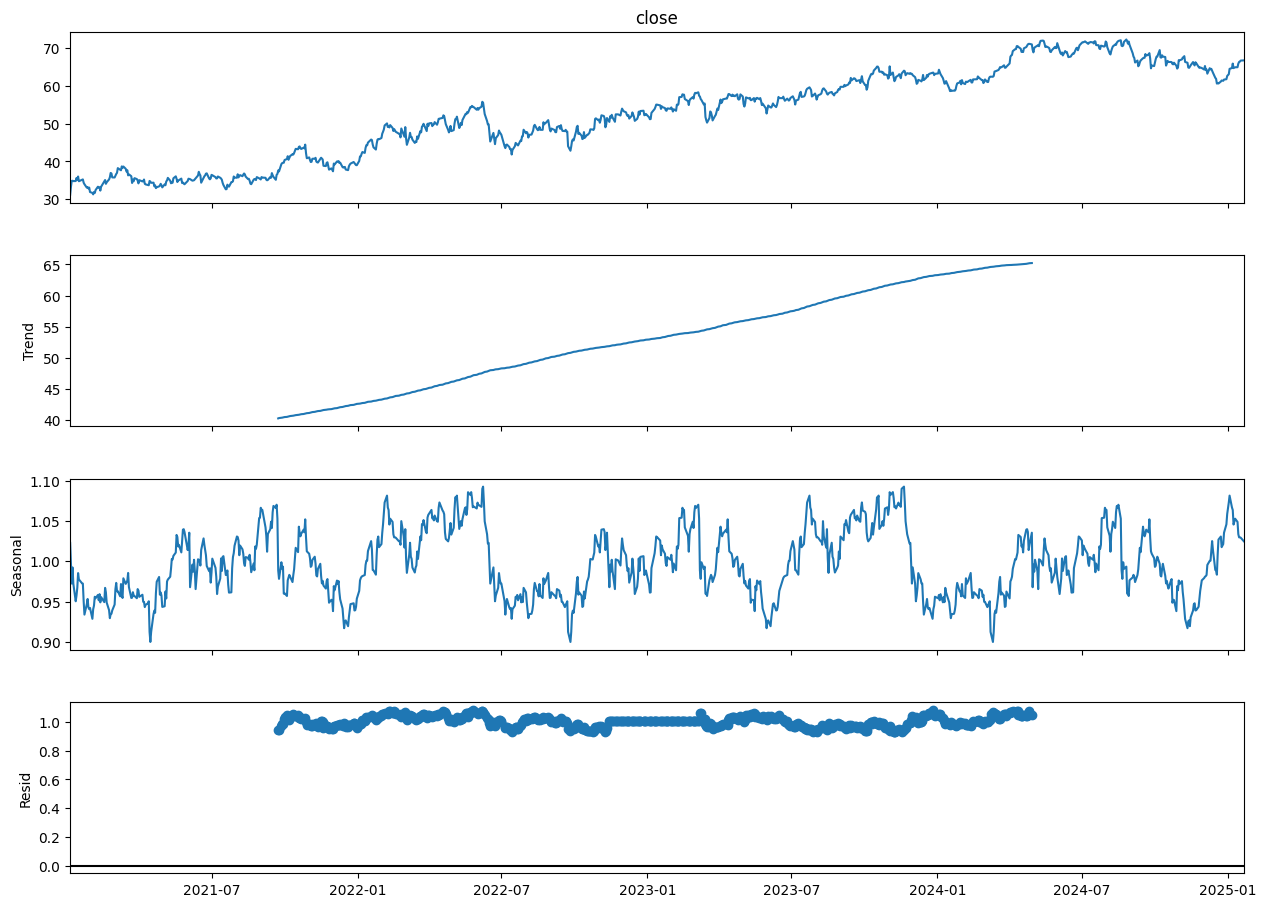

In [98]:
decomposition = seasonal_decompose(shell_stock['close'], model = 'multiplicative', period = 365)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

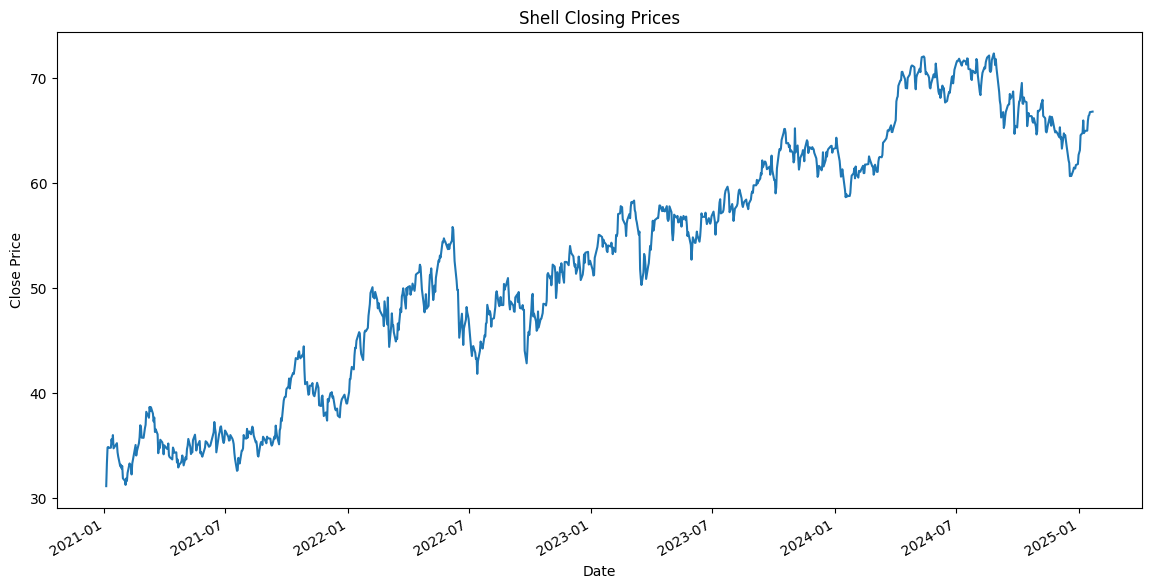

In [99]:
plt.figure(figsize=(14, 7))
shell_stock['close'].plot()
plt.title("Shell Closing Prices")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

C:\Users\Ying\AppData\Local\Temp\ipykernel_23984\1717016293.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shell_stock['rolling_mean'] = shell_stock['close'].rolling(window = 30).mean()


<Figure size 1400x700 with 0 Axes>

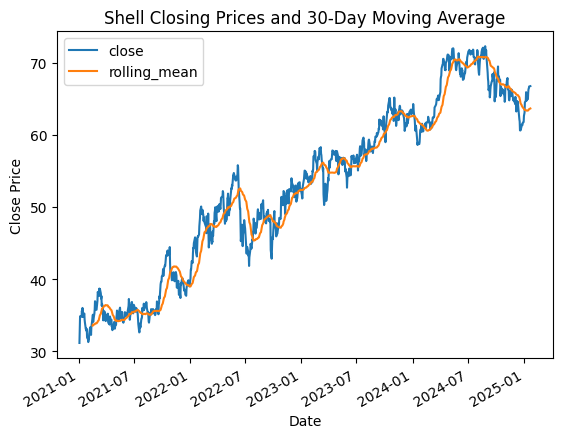

In [100]:
shell_stock['rolling_mean'] = shell_stock['close'].rolling(window = 30).mean()

plt.figure(figsize=(14, 7))
shell_stock[['close', 'rolling_mean']].plot()
plt.title('Shell Closing Prices and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

## Chevron

In [101]:
cvx_stock = stock_data[stock_data['ticker'] == 'CVX']
cvx_stock.set_index('date', inplace = True)

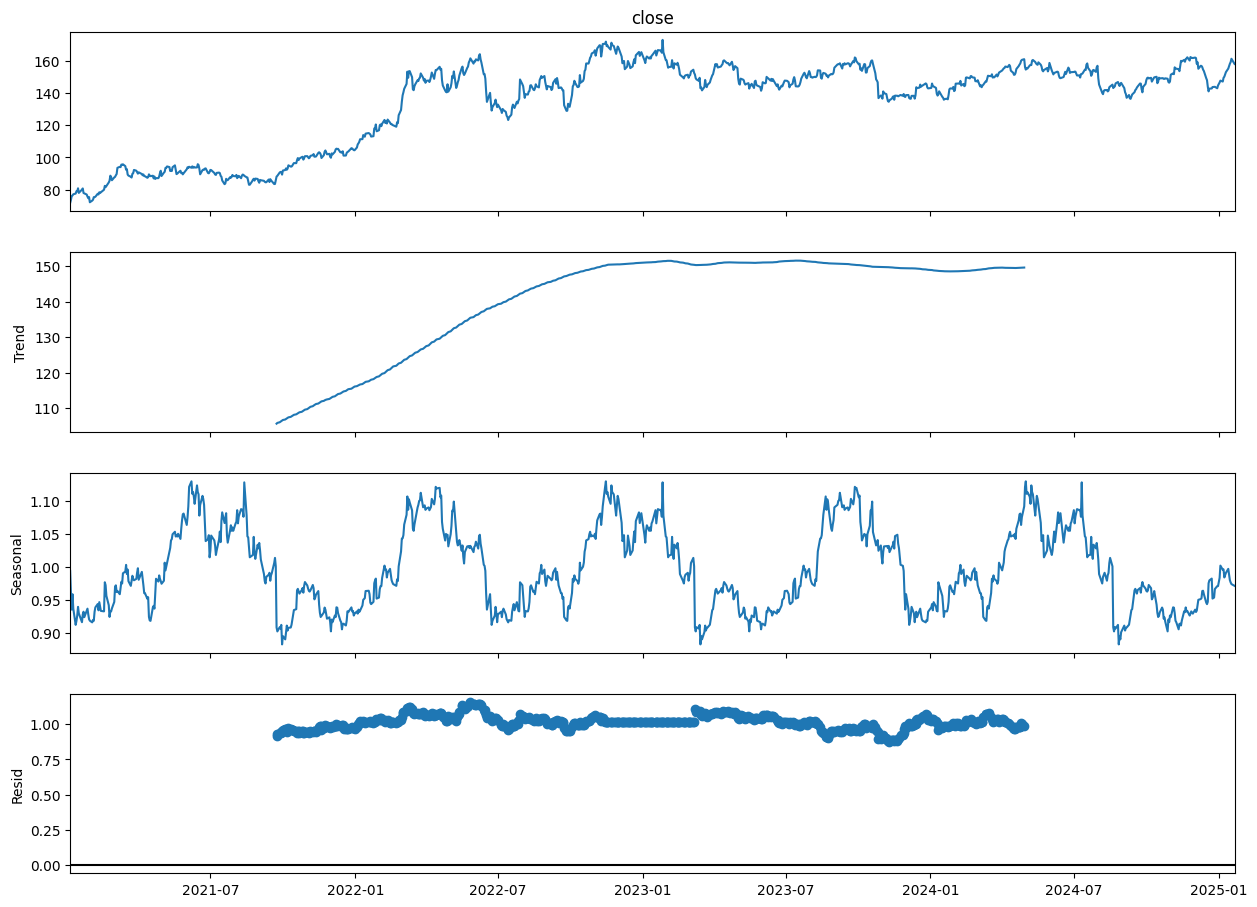

In [102]:
decomposition = seasonal_decompose(cvx_stock['close'], model = 'multiplicative', period = 365)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

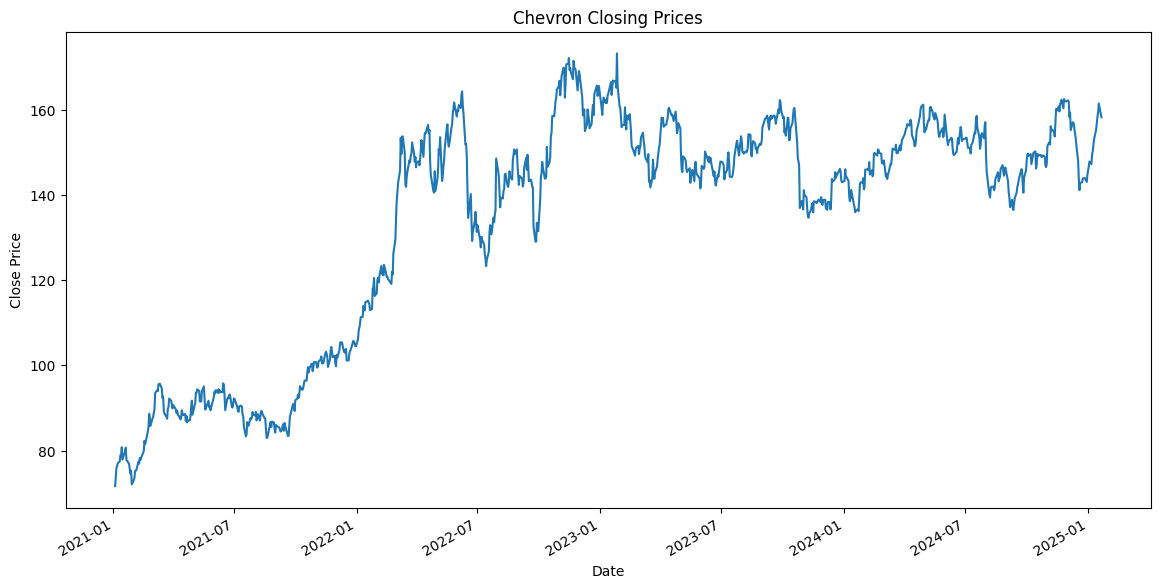

In [103]:
plt.figure(figsize = (14, 7))
cvx_stock['close'].plot()
plt.title('Chevron Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

C:\Users\Ying\AppData\Local\Temp\ipykernel_23984\1352409153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cvx_stock['rolling_mean'] = cvx_stock['close'].rolling(window = 30).mean()


<Figure size 1400x700 with 0 Axes>

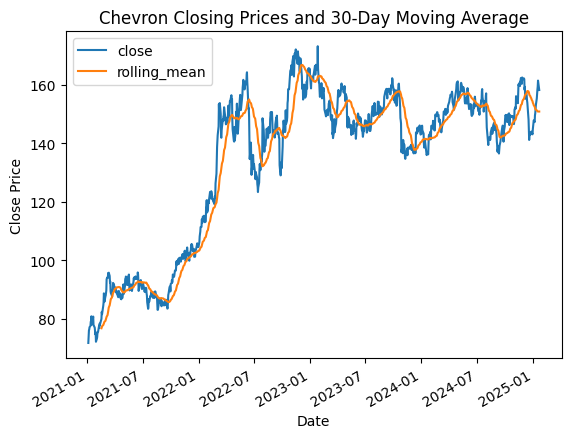

In [104]:
cvx_stock['rolling_mean'] = cvx_stock['close'].rolling(window = 30).mean()

plt.figure(figsize = (14, 7))
cvx_stock[['close', 'rolling_mean']].plot()
plt.title('Chevron Closing Prices and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()